In [1]:
from pathlib import Path
import numpy as np
import torch
import pymeshfix as mf
import nibabel as nib
import pyvista as pv
import nibabel as nib
import dill
import pandas as pd

assert False, "Caution: pyvista plots require a machine with attached physical display or a display emulation (Xvfb package) - otherwise the kernel may die when generating renderings."

AssertionError: Caution: pyvista plots require a machine with attached physical display or a display emulation (Xvfb package) - otherwise the kernel may die when generating renderings.

# Read params from files

In [ ]:
def get_params(params_dir, view):
    df = None
    params_files = list(params_dir.glob(f'{view}_params*.pt'))
    for fl in params_files:
        
        mt = re.match(r".*(train|test).*?([0-9]{1,3})\.pt", str(fl))
        phase, epoch = mt[1], int(mt[2])
        param_dict = torch.load(fl)
        epx_theta_aps = param_dict[f'epx_{view}_theta_aps']
        epx_theta_t_offsets = param_dict[f'epx_{view}_theta_t_offsets']
        epx_theta_zps = param_dict[f'epx_{view}_theta_zps']

        ids = list(zip(*sorted(epx_theta_aps.items())))[0]
        theta_ap = list(zip(*sorted(epx_theta_aps.items())))[1]
        theta_t_offsets = list(zip(*sorted(epx_theta_t_offsets.items())))[1]
        theta_zp = list(zip(*sorted(epx_theta_zps.items())))[1]

        data = dict(
            view=view, 
            sample=ids,
            epoch=epoch,
            theta_ap=[p.detach() for p in theta_ap],
            theta_t_offsets=[p.detach() for p in theta_t_offsets],
            theta_zp=[p.detach() for p in theta_zp],
            phase=phase,
        )

        if df is None:
            df = pd.DataFrame(data)
        else:
            df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

    return df

In [ ]:
params_dir = Path("/shared/slice_inflate/data/output/20230317__13_53_36_fallen-leaf-903-stage-1")
sa_df = get_params(params_dir, 'sa')
with open('sa_params.dill', 'wb') as f:
    dill.dump(sa_df, f)

In [ ]:
params_dir = Path("/shared/slice_inflate/data/output/20230317__13_53_36_fallen-leaf-903-stage-2")
hla_df = get_params(params_dir, 'hla')
with open('hla_params.dill', 'wb') as f:
    dill.dump(hla_df, f)

In [ ]:
newdf = sa_df.query('sample == "1004-mr" & view == "sa"')
newdf

# Create mesh from shape voxels

In [2]:
import numpy as np
import torch
import h5py
import pymeshfix as mf
import nibabel as nib
import pyvista as pv
from pathlib import Path
from skimage import measure

In [3]:
def replace_label_values(label):
    # Replace label numbers with MMWHS equivalent
    # STRUCTURE           MMWHS   ACDC    NNUNET
    # background          0       0       0
    # left_myocardium     205     2       1
    # left_atrium         420     N/A     2
    # ?                   421     N/A     N/A
    # left_ventricle      500     3       3
    # right_atrium        550     N/A     4
    # right_ventricle     600     1       5
    # ascending_aorta     820     N/A     6
    # pulmonary_artery    850     N/A     7
    orig_values = [0,  205, 420, 421, 500, 550, 600, 820, 850]
    new_values = [0,  1,   2,   0,   3,   4,   5,   0,   0]

    modified_label = label.clone()
    for orig, new in zip(orig_values, new_values):
        modified_label[modified_label == orig] = new
    return modified_label

In [4]:
nii_shape = nib.load("mr_train_1004_label_registered.nii.gz")
shape_data = replace_label_values(torch.as_tensor(nii_shape.get_fdata())).long()

In [5]:
shape_affine = torch.as_tensor(nii_shape.affine)
image_sample = nib.load("mr_train_1004_image_registered.nii.gz").get_fdata()
SPACING = (1.,1.,1.)
STEP_SIZE = 2
CLASSES = ['background', 'MYO', 'LA', 'LV', 'RA', 'RV']

heart_data = {}
for class_idx, tag in enumerate(CLASSES):
    if class_idx == 0: continue

    sub_label = torch.nn.functional.one_hot(shape_data.long(), len(CLASSES))[:,:,:, class_idx]
    verts, faces, normals, values = measure.marching_cubes(sub_label.cpu().numpy(), spacing=SPACING, step_size=STEP_SIZE)
    mm_verts = torch.cat([torch.tensor(verts.copy()), torch.ones(len(verts),1)], dim=1)
    mm_verts = (shape_affine @ mm_verts.T.double()).T[:,:3]

    data = dict(
        verts=torch.as_tensor(mm_verts.numpy().copy()),
        faces=torch.as_tensor(faces.copy()),
        normals=torch.as_tensor(normals.copy()), 
        values=torch.as_tensor(values.copy())
    )
    heart_data[tag] = data

In [6]:
hla_mat = torch.from_numpy(np.loadtxt("mmwhs_1002_SA.mat"))
sa_mat = torch.from_numpy(np.loadtxt("mmwhs_1002_4CH.mat"))

In [7]:
def compute_rotation_matrix_from_ortho6d(ortho):
    # see https://github.com/papagina/RotationContinuity/blob/master/Inverse_Kinematics/code/tools.py
    x_raw = ortho[:, 0:3]
    y_raw = ortho[:, 3:6]

    x = x_raw / x_raw.norm(dim=1, keepdim=True)
    z = x.cross(y_raw)
    z = z / z.norm(dim=1, keepdim=True)
    y = z.cross(x)

    # torch.stack([x, y, z], dim=-1)
    r00 = x[:,0]
    r01 = y[:,0]
    r02 = z[:,0]
    r10 = x[:,1]
    r11 = y[:,1]
    r12 = z[:,1]
    r20 = x[:,2]
    r21 = y[:,2]
    r22 = z[:,2]
    zer = torch.zeros_like(r00)
    one = torch.ones_like(r00)

    theta_r = torch.stack(
        [r00, r01, r02, zer,
         r10, r11, r12, zer,
         r20, r21, r22, zer,
         zer, zer, zer, one], dim=1)

    theta_r = theta_r.view(-1,4,4)

    return theta_r



def construct_optimized_mat(theta_ap, theta_t_offsets, theta_zp):    
    theta_a = compute_rotation_matrix_from_ortho6d(theta_ap.view(1,6))[0].view(1,4,4)
    theta_t = torch.cat([theta_t_offsets, torch.tensor([1])])
    theta_t = torch.cat([torch.eye(4)[:4,:3], theta_t.view(4,1)], dim=1).view(1,4,4)
    theta_z = torch.diag_embed(torch.cat([
        theta_zp.view(1,1),
        theta_zp.view(1,1),
        theta_zp.view(1,1),
        torch.ones([1,1])], dim=-1
    ))

    return theta_z @ theta_a @ theta_t

In [8]:
import dill
import pandas as pd

with open('sa_params.dill', 'rb') as f:
    sa_df = dill.load(f)

with open('hla_params.dill', 'rb') as f:
    hla_df = dill.load(f)

df = pd.concat([sa_df, hla_df], ignore_index=True)

smp = df.query('sample == "1004-mr" & view == "sa" & epoch == 20')

optimized_sa_mat_1004 = construct_optimized_mat(*smp.theta_ap, *smp.theta_t_offsets, *smp.theta_zp)
optimized_hla_mat_1004 = optimized_sa_mat_1004

In [9]:
# optimized_sa_mat_1004 = torch.tensor(
#     [[[ 0.3762,  0.0235, -0.9262,  0.0000],
#       [ 0.6500,  0.7056,  0.2820,  0.0000],
#       [ 0.6602, -0.7082,  0.2502,  0.0000],
#       [ 0.0000,  0.0000,  0.0000,  1.0000]]]
# )

# optimized_hla_mat_1004 = torch.tensor(
#     [[[ 0.8096, -0.5865,  0.0236,  0.0000],
#       [ 0.5751,  0.7844, -0.2325,  0.0000],
#       [ 0.1178,  0.2018,  0.9723,  0.0000],
#       [ 0.0000,  0.0000,  0.0000,  1.0000]]]
# )

In [10]:
from align_mmwhs import nifti_transform
FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([160,160,160])

with torch.no_grad():
    sa_label, sa_affine, sa_grid_affine = nifti_transform(shape_data.unsqueeze(0).unsqueeze(0), shape_affine.unsqueeze(0), sa_mat.unsqueeze(0), 
        fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, 
        pre_grid_sample_affine=optimized_sa_mat_1004,
        # pre_grid_sample_affine=None
    )
    
    hla_label, hla_affine, hla_grid_affine = nifti_transform(shape_data.unsqueeze(0).unsqueeze(0), shape_affine.unsqueeze(0), hla_mat.unsqueeze(0), 
        fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, 
        pre_grid_sample_affine=optimized_hla_mat_1004,
        # pre_grid_sample_affine=None
    )


/Users/christianweihsbach/code/shapeformer_postprocessing/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


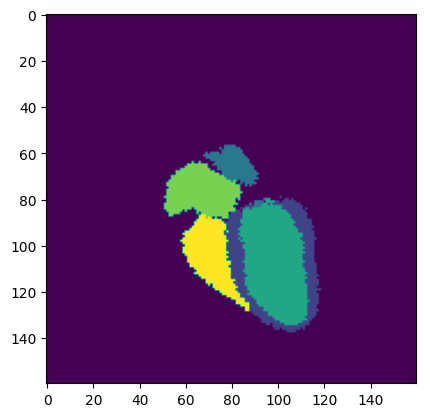

In [11]:
from matplotlib import pyplot as plt
plt.imshow(sa_label.squeeze()[:,:,80].T)

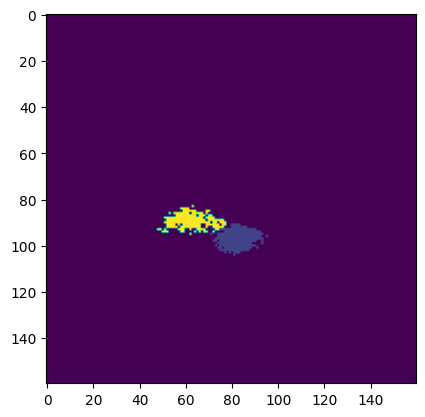

In [12]:
from matplotlib import pyplot as plt
plt.imshow(hla_label.squeeze()[:,:,80].T)

In [13]:
# Nifti original plane slicing.
# sa_normal = torch.tensor([1.,0.,0.])  # working! for D slicing
# sa_normal = torch.tensor([0.,1.,0.])  # working! for H slicing

sa_normal = torch.tensor([0.,0.,1.])  # working! for W slicing
sa_support = (shape_affine @ torch.tensor([64.,64.,64.,1.]).double())[:3]
print("Non transformed", sa_normal, sa_support)

# SA slicing
sa_normal = (sa_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
sa_support = (sa_affine @ torch.tensor([80.,80.,80.,1.]).double())[0,:3]

print("Transformed SA", sa_normal, sa_support)

hla_normal = (hla_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
hla_support =(hla_affine @ torch.tensor([80.,80.,80.,1.]).double())[0,:3]
print("Transformed HLA", hla_normal, hla_support)

Non transformed tensor([0., 0., 1.]) tensor([-48.5884,  -7.7177,  -6.8419], dtype=torch.float64)
Transformed SA tensor([ 0.6808,  0.4035, -1.3687], dtype=torch.float64) tensor([-47.7470,   1.2547,  -1.1101], dtype=torch.float64)
Transformed HLA tensor([-0.9164,  1.1338,  0.6121], dtype=torch.float64) tensor([-93.4619,  14.4908,  -4.8804], dtype=torch.float64)


In [14]:
h_vertices = heart_data['MYO']['verts']
h_faces = heart_data['MYO']['faces']

for tag, data in heart_data.items():
    faces = data['faces']
    num_faces = faces.shape[0]
    num_points = torch.tensor([3]*num_faces).view(num_faces,1)
    data['pyvista_faces'] = torch.cat([num_points, faces], dim=1)

In [15]:
# https://coolors.co/b8336a-726da8-7d8cc4-a0d2db-c490d1

palette = [
    '#B8336A',
    '#726DA8',
    '#7D8CC4',
    '#A0D2DB',
    '#C490D1',
]
dark_palette = [
    '#4F172E', 
    '#424064',
    '#485070',
    '#547378',
    '#73507C',
]

/Users/christianweihsbach/code/shapeformer_postprocessing/.venv/lib/python3.9/site-packages/pyvista/plotting/plotting.py:5523: UserWarning: 
Set `jupyter_backend` backend to `"none"` to take a screenshot within a notebook environment.
  warnings.warn(


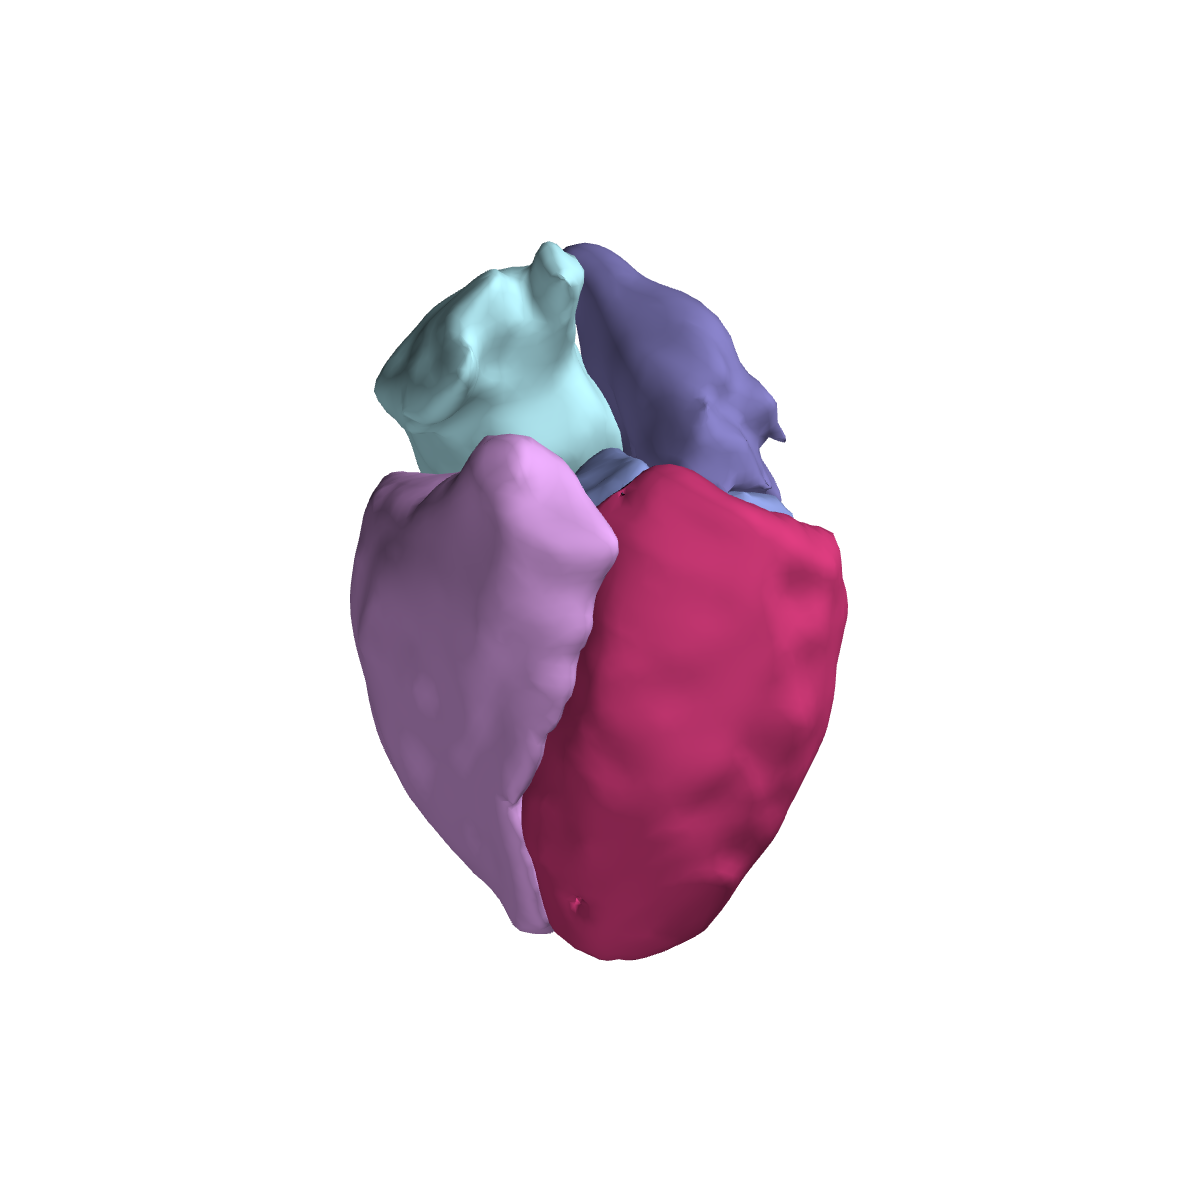

In [16]:
SHOW_FULL_MESH = True

SHOW_SA_PLANE = False
SHOW_SA_SLICE = False

SHOW_HLA_PLANE = False
SHOW_HLA_SLICE = False

ORIENTATION = 'custom'

assert ORIENTATION in ['custom', 'HLA', 'SA']

plotter = pv.Plotter(
    lighting='three lights'
)
plotter.background_color = "white"

cpos = 'iso'
sa_plane = pv.Plane(center=sa_support.tolist(), direction=sa_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
sa_plane.point_data.clear()
sa_edges = sa_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)

hla_plane = pv.Plane(center=hla_support.tolist(), direction=hla_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
hla_plane.point_data.clear()
hla_edges = hla_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)

full_mesh = []

# Prepare meshes
for idx, (tag, data) in enumerate(heart_data.items()):
    surf = pv.PolyData(data['verts'].numpy(), data['pyvista_faces'].view(-1).numpy())
    scalars=np.array([idx]*data['verts'].shape[0])
    surf.point_data.set_scalars(scalars, 'scalars')
    # full_mesh.append(surf)
    smooth = surf.smooth_taubin(n_iter=100, pass_band=0.3)
    full_mesh.append(smooth)

block = pv.MultiBlock(full_mesh)
full_mesh = block.combine(merge_points=False)

sa_slice = full_mesh.slice(normal=sa_normal.tolist(), origin=sa_support.tolist())
hla_slice = full_mesh.slice(normal=hla_normal.tolist(), origin=hla_support.tolist())

if SHOW_FULL_MESH:
    plotter.add_mesh(full_mesh, name='all', cmap=palette, line_width=2, show_scalar_bar=False, smooth_shading=True)   

if SHOW_SA_SLICE:
    plotter.add_mesh(sa_slice, name='sa_slice', cmap=dark_palette, line_width=2, show_scalar_bar=False) 

if SHOW_SA_PLANE:   
    plotter.add_mesh(sa_plane, color=palette[idx],  opacity=0.3, show_edges=False, line_width=2)
    plotter.add_mesh(sa_edges, color=dark_palette[idx], line_width=1)

if SHOW_HLA_SLICE:
    plotter.add_mesh(hla_slice, name='hla_slice', cmap=dark_palette, line_width=2, show_scalar_bar=False)

if SHOW_HLA_PLANE:    
    plotter.add_mesh(hla_plane, color=palette[idx],  opacity=0.3, show_edges=False, line_width=2)
    plotter.add_mesh(hla_edges, color=dark_palette[idx], line_width=1)

plotter.view_isometric()
plotter.enable_parallel_projection()


if ORIENTATION == 'HLA':
    plotter.camera.position = (hla_support+hla_normal).tolist()
    plotter.camera.focal_point = hla_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)


elif ORIENTATION == 'SA':
    plotter.camera.position = (sa_support+sa_normal).tolist()
    plotter.camera.focal_point = sa_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)
else:
    CPOS = [(-197.83877598229623, 115.84841835647464, 308.3400332147713),
 (-60.352217898947785, -8.401068746929688, -10.565500454759558),
 (0.8644550419037054, -0.21263129938713254, 0.45552761831551225)]
    plotter.camera.zoom(.8)

    
plotter.show(
    window_size=[1200,1200], 
    jupyter_backend='static',
    cpos=CPOS, 
    screenshot='optimized.png'
)

In [40]:
plotter.camera_position

[(209.2207705021671, -275.7904587797502, -518.9463886550571),
 (-74.73036258375254, 5.154448101887414, 9.022559632140428),
 (0.7768819378130275, -0.2772185334716578, 0.565335598914219)]

In [60]:
import numpy as np
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = axis / axis.dot(axis).sqrt()
    a = (theta / 2.0).cos()
    b, c, d = -axis * (theta / 2.0).sin()
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [65]:
from tqdm import tqdm

SHOW_FULL_MESH = True

PLANE_SIZE_MM = 224

SHOW_SA_PLANE = True
SHOW_SA_SLICE = True

SHOW_HLA_PLANE = True
SHOW_HLA_SLICE = True

ORIENTATION = 'custom'
assert ORIENTATION in ['custom', 'HLA', 'SA']

GIF_NAME = 'anim.gif'

plotter = pv.Plotter(
    lighting='three lights'
)
plotter.window_size=[1200,1200]
plotter.background_color = "white"
plotter.view_isometric()
plotter.enable_parallel_projection()

if ORIENTATION == 'HLA':
    plotter.camera.position = (hla_support+hla_normal).tolist()
    plotter.camera.focal_point = hla_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)
elif ORIENTATION == 'SA':
    plotter.camera.position = (sa_support+sa_normal).tolist()
    plotter.camera.focal_point = sa_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(.8)
else:
    CPOS = torch.tensor([
        (209.2207705021671, -275.7904587797502, -518.9463886550571),
        (-74.73036258375254, 5.154448101887414, 9.022559632140428),
        (0.7768819378130275, -0.2772185334716578, 0.565335598914219)]
    )
    # plotter.camera_position = CPOS
    plotter.camera.position = CPOS[0].numpy()
    plotter.camera.focal_point = CPOS[1].numpy()
    plotter.camera.up = CPOS[2].numpy()
    plotter.camera.zoom(.003)

def get_rotated_cpos_closure(camera):
    up = torch.as_tensor(camera.up)
    focal_point = torch.as_tensor(camera.focal_point)
    position = torch.as_tensor(camera.position)

    def set_rotated_cpos(deg_angle):
        diff = position - focal_point
        rot_mat = torch.as_tensor(rotation_matrix(up, deg_angle/180*np.pi))
        
        new_diff = rot_mat @ diff
        new_position = new_diff + focal_point
        camera.position = new_position.numpy()

    return set_rotated_cpos


set_rotated_cpos = get_rotated_cpos_closure(plotter.camera)

plotter.open_gif(GIF_NAME)

full_mesh = []

# Prepare meshes
for idx, (tag, data) in enumerate(heart_data.items()):
    surf = pv.PolyData(data['verts'].numpy(), data['pyvista_faces'].view(-1).numpy())
    scalars=np.array([idx]*data['verts'].shape[0])
    surf.point_data.set_scalars(scalars, 'scalars')
    # full_mesh.append(surf)
    smooth = surf.smooth_taubin(n_iter=100, pass_band=0.3)
    full_mesh.append(smooth)

block = pv.MultiBlock(full_mesh)
full_mesh = block.combine(merge_points=False)

if SHOW_FULL_MESH:
    plotter.add_mesh(full_mesh, name='all', cmap=palette, line_width=2, show_scalar_bar=False, smooth_shading=True)   

# smps = df.query('sample == "1004-mr" & view == "sa"').sort_values('epoch', ascending=True)
# smps = df.query('sample == "1004-mr" & view == "hla"')
smps = df.query('sample == "1004-mr"')

sa_slice_actors = []
hla_slice_actors = []

for frame_idx, sample_idx in enumerate(tqdm(smps.index)):
    set_rotated_cpos(torch.tensor(frame_idx*2.))

    smp = smps.loc[sample_idx]

    optimized_mat = construct_optimized_mat(
        smp.theta_ap, smp.theta_t_offsets, smp.theta_zp
    )

    if smp['view'] == 'sa':
        base_mat = sa_mat
    else:
        base_mat = hla_mat

    with torch.no_grad():
        _, optimized_nii_affine_affine, optimized_grid_affine = nifti_transform(
            shape_data.unsqueeze(0).unsqueeze(0), shape_affine.unsqueeze(0), base_mat.unsqueeze(0), 
            fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, 
            pre_grid_sample_affine=optimized_mat,
            # pre_grid_sample_affine=None
        )

    if smp['view'] == 'sa':
        while len(sa_slice_actors):
            actor = sa_slice_actors.pop()
            plotter.remove_actor(actor)

        # SA slicing
        sa_normal = (optimized_nii_affine_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
        sa_support = (optimized_nii_affine_affine @ torch.tensor([80.,80.,80.,1.]).double())[0,:3]
        sa_plane = pv.Plane(center=sa_support.tolist(), direction=sa_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
        sa_plane.point_data.clear()
        sa_edges = sa_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
        sa_slice = full_mesh.slice(normal=sa_normal.tolist(), origin=sa_support.tolist())

        if SHOW_SA_SLICE:
            slc_actor = plotter.add_mesh(sa_slice, name='sa_slice', cmap=dark_palette, line_width=2, show_scalar_bar=False) 
            sa_slice_actors.append(slc_actor)

        if SHOW_SA_PLANE:   
            slc_actor = plotter.add_mesh(sa_plane, color=palette[0],  opacity=0.3, show_edges=False, line_width=2)
            sa_slice_actors.append(slc_actor)
            slc_actor = plotter.add_mesh(sa_edges, color=dark_palette[0], line_width=1)
            sa_slice_actors.append(slc_actor)

    if smp['view'] == 'hla':
        while len(hla_slice_actors):
            actor = hla_slice_actors.pop()
            plotter.remove_actor(actor)

        # HLA slicing
        hla_normal = (optimized_nii_affine_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
        hla_support = (optimized_nii_affine_affine @ torch.tensor([80.,80.,80.,1.]).double())[0,:3]
        hla_plane = pv.Plane(center=hla_support.tolist(), direction=hla_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
        hla_plane.point_data.clear()
        hla_edges = hla_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
        hla_slice = full_mesh.slice(normal=hla_normal.tolist(), origin=hla_support.tolist())

        if SHOW_HLA_SLICE:
            slc_actor = plotter.add_mesh(hla_slice, name='hla_slice', cmap=dark_palette, line_width=2, show_scalar_bar=False)
            hla_slice_actors.append(slc_actor)

        if SHOW_HLA_PLANE:    
            slc_actor = plotter.add_mesh(hla_plane, color=palette[1],  opacity=0.3, show_edges=False, line_width=2)
            hla_slice_actors.append(slc_actor)
            slc_actor = plotter.add_mesh(hla_edges, color=dark_palette[1], line_width=1)
            hla_slice_actors.append(slc_actor)

    # plotter.show()
    # break
    plotter.write_frame()


# Closes and finalizes movie
plotter.close()

  0%|          | 0/480 [00:00<?, ?it/s]/Users/christianweihsbach/code/shapeformer_postprocessing/.venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 480/480 [02:33<00:00,  3.13it/s]
